# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [4]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [5]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [6]:
len(plant_chemical_df.chemical_curie.unique())

87019

### Extract chemical classes

Load NPClassifier classes

In [9]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [10]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [11]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [12]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89271/89271 [00:00<00:00, 420706.60it/s]


In [14]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

52430

### Compound class annotation

In [20]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [21]:
# all plants
np_classifier_annotated_plants.shape

(415969, 3)

In [22]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

In [23]:
np_classifier_annotated_plants.shape

(308674, 3)

In [24]:
np_classifier_annotated_plants['class'].value_counts()

Flavonols                         19928
Flavones                          12642
Cinnamic acids and derivatives     9523
Oleanane triterpenoids             8778
Simple phenolic acids              7415
                                  ...  
Carotenoids (C40, β-γ)                1
Linear tetronates                     1
Dunniane sesquiterpenoids             1
RiPPs-Lasso peptides                  1
3-oligoenoyltetramic acids            1
Name: class, Length: 566, dtype: int64

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [25]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [26]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors: 100%|██████████| 17907/17907 [1:10:05<00:00,  4.26it/s]


In [27]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Monomeric stilbenes,Coloratane sesquiterpenoids,Macrolide lactones,Angucyclines,Oxygenated hydrocarbons,Acetogenins,Hydroxy-hydroperoxyeicosatrienoic acids,Podocarpane diterpenoids,Streptogramins,Dibenzylbutane lignans,Open-chained neoflavonoids,Longipinane sesquiterpenoids,Ergot alkaloids,Noreudesmane sesquiterpenoids,Carbazole alkaloids,Clavulones,Phytofurans,Yohimbine-like alkaloids,"Carotenoids (C40, κ-Χ)","Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Silphiperfolane sesquiterpenoids,Secokaurane diterpenoids,Taxane diterpenoids,Pseudopterane diterpenoids,Fatty acyl homoserine lactones,Melithiazole and Myxothiazole derivatives,Verrucosane diterpenoids,Copaane sesquiterpenoids,Noreremophilane sesquiterpenoids,Furocoumarins,"Carotenoids (C40, ε-ε)",Penicillins,Himachalane sesquiterpenoids,Viscidane diterpenoids,Abietane diterpenoids,Terpenoid alkaloids,N-acyl ethanolamines (endocannabinoids),Aporphine alkaloids,Methyl xanthones,Cephalotaxus alkaloids,Flavans,Tetrahydroisoquinoline alkaloids,Amino fatty acids,Megastigmanes,Catechols with side chains,Fatty aldehydes,Africanane sesquiterpenoids,Methoxy fatty acids,Depsidones,Glycosylmonoacylglycerols,Eudesmane sesquiterpenoids,Thiodiketopiperazine alkaloids,Cyclonerane sesquiterpenoids,Tetracyclic diterpenoids,Fatty nitriles,Purine alkaloids,Aspidosperma-Iboga hybrid type (Vinca alkaloids),Oxasqualenoids,Cyclofarnesane sesquiterpenoids,Paraconic acids and derivatives,Dialkylresorcinols,Benzodiazepine alkaloids,Spirovetivane sesquiterpenoids,Wax monoesters,Pyrrole alkaloids,Microcystins,Tripeptides,Gorgonane sesquiterpenoids,Coumestan,Arteminisin,Dimeric phloroglucinols,Rhamnolipids,Prenylbisabolane diterpenoids,Phenylethylamines,Pimarane and Isopimarane diterpenoids,Zearalenones,Fatty acyl CoAs,Guanacastane diterpenoids,Multiflorane triterpenoids,Cyclogermacrane sesquiterpenoids,Cubebane sesquiterpenoids,Sphaerane diterpenoids,Oxo fatty acids,RiPPs-Cyanobactins,Thujane monoterpenoids,m-Terphenyls,Grayanotoxane diterpenoids,Menthane monoterpenoids,Panasinsane sesquiterpenoids,Eremophilane sesquiterpenoids,Cycloapotirucallane triterpenoids,Decalins with side chains,Ecdysteroids,Stictane triterpenoids,Carane monoterpenoids,Villanovane diterpenoids,Bleomycins,Flavan-3-ols,Cycloeudesmane sesquiterpenoids,Copacamphane sesquiterpenoids,Bicyclohumulane sesquiterpenoids,Fukinane sesquiterpenoids,Shikimic acids and derivatives,Humulane sesquiterpenoids,Oligomycins,Simple oxindole alkaloids,Protoilludane sesquiterpenoids,Cycloartane triterpenoids,Carbapenems,Tetraketide meroterpenoids,Depsipeptides,Indole-Diterpenoid alkaloids (Penitrems),Glucosinolates,Secochamigrane sesquiterpenoids,Filicane triterpenoids,Daucane sesquiterpenoids,Glutinane triterpenoids,Abeolupane triterpenoids,Stigmastane steroids,Santalane sesquiterpenoids,Fasamycins and derivatives,3-Decalinoyltetramic acids,Gallotannins,Gibberellins,Cryptophycins,Strobilurins and derivatives,Patchoulane sesquiterpenoids,Ahp-containing cyclodepsipeptides,"Indole diketopiperazine alkaloids (L-Trp, L-Trp)",Chalcones,Protopine alkaloids,Arylnaphthalene and aryltetralin lignans,"Carotenoids (C40, β-ε)",Rhamnofolane diterpenoids,Glycerophosphoglycerols,N-acyl amines,Farnesane sesquiterpenoids,Glycerophosphoethanolamines,"Carotenoids (C40, κ-κ)",Dammarane and Protostane triterpenoids,Isoquinoline alkaloids,Gymnomitrane sesquiterpenoids,Neoflavonoids,Androstane steroids,Dibenzylbutyrolactone lignans,Isocomane sesquiterpenoids,Carbocyclic fatty acids,Elemane sesquiterpenoids,Homoerythrina alkaloids,Labdane diterpenoids,Fernane and Arborinane triterpenoids,Cyclic peptides,Fungal DPEs,Ursane and Taraxastane triterpenoids,Adianane triterpenoids,Spongiane diterpenoids,Peptaibols,Phenanthrenes,Briarane diterpenoids,Lippifoliane sesquiterpenoids,Spiroaxane sesquiterpenoids,Stemona alkaloids,Erythroxylane diterpenoids,Longibornane sesquiterpenoids,Valparane diterpenoids,Abeoabietane diterpenoids,Tremulane sesquiterpenoids,Jatrophola

### Collapsing plant species to plant families

In [30]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 27588.10it/s]


# TODO: Plot the number of chemicals per family/genus

In [31]:
def plot_chemical_distribution(taxon_to_species):
    """Plot chemical distribution."""
    
    rows = []
    
    for taxon_name, species in tqdm(taxon_to_species.items()):
        unique_chemicals = plant_chemical_df[
            plant_chemical_df['plant_curie'].isin(species)
        ].chemical_curie.unique()
        
        rows.append({
            'taxon_group': taxon_name,
            'chemical_count': len(unique_chemicals),
        })
        
    df = pd.DataFrame(rows)
    df.set_index('taxon_group', inplace=True)
    
    g = sns.displot(
        data=df,
        x='chemical_count',
        stat="density",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
    )

#     g.set(xlim=(-1, 10000))

    plt.show()

100%|██████████| 4843/4843 [00:47<00:00, 101.69it/s]


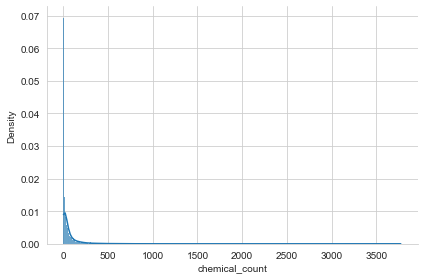

In [32]:
plot_chemical_distribution(genus_to_species)

100%|██████████| 513/513 [00:06<00:00, 79.04it/s]


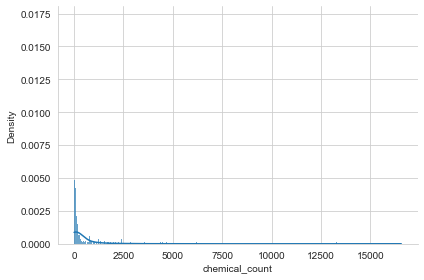

In [33]:
plot_chemical_distribution(family_to_species)

# TODO: Fixme and export without medicinal and non medicinal but all together

In [34]:
def collapse_to_family(df: pd.DataFrame, taxon_group):
    
    data = []
    skipped_empty = 0
    skipped_low = 0
    
    for family_curie, species in tqdm(taxon_group.items()):
        tmp_df = df[df['plant_name'].isin(species)]
        
        if tmp_df.empty:
            skipped_empty +=1
            continue
            
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        # Remove family/genus with chemical class less than 10
        if tmp_df.sum().sum() < 10:
            skipped_low +=1
            continue
        
        row_dict = tmp_df.sum().to_dict()
        row_dict['taxon'] = family_curie
        
        data.append(row_dict)

    print('Empty skipped empty:', skipped_empty)
    print('Empty skipped less than 10 chemicals:', skipped_low)
    
    df = pd.DataFrame(data)
    df.set_index('taxon', inplace=True)
    df.fillna(0, inplace=True)

    return df

In [36]:
np_classifier_family_df = collapse_to_family(plant_to_npclassifier_vectors, family_to_species)
np_classifier_genus_df = collapse_to_family(plant_to_npclassifier_vectors, genus_to_species)

100%|██████████| 513/513 [00:01<00:00, 295.66it/s]


Empty skipped empty: 24
Empty skipped less than 10 chemicals: 108


100%|██████████| 4843/4843 [00:13<00:00, 361.01it/s]


Empty skipped empty: 348
Empty skipped less than 10 chemicals: 1803


In [37]:
np_classifier_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_family_vector.tsv', sep='\t'
)
np_classifier_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_genus_vector.tsv', sep='\t'
)